# Task 7 — Ratios, Ablations, and Statistics (SimCLR + SimSiam)

This notebook consolidates **downstream evaluations**, **ablations**, and **statistical tests** for the two SSL notebooks you have:

- **SimCLR** (from `ssl-1 (1).ipynb`)
- **SimSiam** (from `Task-(5+6) - Simsiam SSL Part ... .ipynb`)

✅ Deliverables included here:
- Ablation tables (linear-probe + label-efficiency)
- Statistical tests (paired t-test; Friedman + Nemenyi post-hoc)
- 1–2 effect-size figures (Cohen’s d + mean differences)

> **How to use:** run cells top-to-bottom.  
> If you already have trained checkpoints, set `USE_PRETRAINED=True` and point paths to your `.pth` encoders.


In [41]:
# ==== Install/Imports ====
import os, random, math
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, Subset

from torchvision import transforms
from torchvision.datasets import ImageFolder

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

from scipy import stats
from statsmodels.stats.libqsturng import psturng

import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

def seed_all(seed: int = 42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_all(42)


device: cuda


## 1) Common dataset loader

Both of your original notebooks use **ImageFolder-style** datasets (folder per class).  
Set `DATA_DIR` to your dataset root (the folder that contains class subfolders).

In [42]:
# ==== Set your dataset root ====
DATA_DIR = "/kaggle/input/betel/Controlled Environment"
assert os.path.exists(DATA_DIR), f"DATA_DIR not found: {DATA_DIR}"
print("DATA_DIR OK:", DATA_DIR)

# Basic eval transform (same for all downstream tasks)
eval_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

full_ds = ImageFolder(DATA_DIR, transform=eval_transform)
X = np.arange(len(full_ds))
y = np.array([full_ds[i][1] for i in range(len(full_ds))])
num_classes = len(full_ds.classes)

print("N:", len(full_ds), "classes:", num_classes, full_ds.classes[:5])


DATA_DIR OK: /kaggle/input/betel/Controlled Environment
N: 893 classes: 3 ['Diseased', 'Dried', 'Healthy']


## 2) Train:test grid (same idea as Task 2)

If your Task 2 used a specific grid, put it in `TRAIN_TEST_GRID` below.  
Default: **(90:10), (80:20), (70:30)**.

We evaluate each setting using **Stratified K-Fold** on the *train portion* and keep test held out.


In [49]:
# ==== Train:test grid ====
TRAIN_TEST_GRID = [
    {"name": "90_10", "test_size": 0.10},
    {"name": "80_20", "test_size": 0.20},
    {"name": "70_30", "test_size": 0.30},
]

N_FOLDS = 5
SEED = 42


In [56]:
def make_splits(X, y, test_size: float, n_folds: int, seed: int):
    # 1) Hold-out test split
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
    train_idx, test_idx = next(sss.split(X, y))
    X_train, y_train = X[train_idx], y[train_idx]

    # 2) K-fold on train split (for paired stats across identical folds)
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
    folds = []
    for tr, va in skf.split(X_train, y_train):
        folds.append({
            "train_idx": train_idx[tr],
            "val_idx": train_idx[va],
            "test_idx": test_idx
        })
    return folds


## 3) Metrics helpers

In [59]:
def compute_metrics(y_true, y_pred):
    return {
        "acc": float(accuracy_score(y_true, y_pred)),
        "f1_macro": float(f1_score(y_true, y_pred, average="macro")),
    }

@torch.no_grad()
def extract_features(encoder: nn.Module, loader: DataLoader):
    encoder.eval()
    feats, labels = [], []
    for xb, yb in loader:
        xb = xb.to(device)
        z = encoder(xb)
        if isinstance(z, (tuple, list)):  # safety
            z = z[0]
        feats.append(z.detach().cpu().numpy())
        labels.append(yb.numpy())
    return np.concatenate(feats, axis=0), np.concatenate(labels, axis=0)


## 4) Downstream evaluators

We do:
- **Linear probe**: freeze encoder, train a single linear layer on train fold, validate on val fold, report on test.
- **Label efficiency**: train linear probe using only `{1,5,10,25,50}%` of labeled train-fold data, evaluate on test.

> Tip: keep epochs small for quick runs, then increase for final reporting.


In [64]:
class LinearProbe(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.fc = nn.Linear(in_dim, num_classes)
    def forward(self, x): return self.fc(x)

def fit_linear_probe(train_feats, train_y, val_feats, val_y, num_classes, 
                     lr=1e-3, wd=1e-4, epochs=50, batch_size=256, seed=42):
    seed_all(seed)
    in_dim = train_feats.shape[1]
    model = LinearProbe(in_dim, num_classes).to(device)

    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    loss_fn = nn.CrossEntropyLoss()

    # Torch tensors
    Xtr = torch.tensor(train_feats, dtype=torch.float32)
    ytr = torch.tensor(train_y, dtype=torch.long)
    Xva = torch.tensor(val_feats, dtype=torch.float32)
    yva = torch.tensor(val_y, dtype=torch.long)

    best_state, best_acc = None, -1.0
    for ep in range(epochs):
        model.train()
        idx = torch.randperm(len(Xtr))
        for i in range(0, len(Xtr), batch_size):
            b = idx[i:i+batch_size]
            xb = Xtr[b].to(device); yb = ytr[b].to(device)
            opt.zero_grad()
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            opt.step()

        # quick val
        model.eval()
        pred = model(Xva.to(device)).argmax(1).detach().cpu().numpy()
        acc = accuracy_score(val_y, pred)
        if acc > best_acc:
            best_acc = acc
            best_state = {k:v.detach().cpu().clone() for k,v in model.state_dict().items()}

    if best_state is not None:
        model.load_state_dict(best_state)
    return model

def evaluate_linear_probe_for_split(encoder, full_ds, split, num_classes,
                                   feat_bs=128, lp_epochs=50, seed=42):
    # loaders
    tr = DataLoader(Subset(full_ds, split["train_idx"]), batch_size=feat_bs, shuffle=False, num_workers=0)
    va = DataLoader(Subset(full_ds, split["val_idx"]),   batch_size=feat_bs, shuffle=False, num_workers=0)
    te = DataLoader(Subset(full_ds, split["test_idx"]),  batch_size=feat_bs, shuffle=False, num_workers=0)

    trF, trY = extract_features(encoder, tr)
    vaF, vaY = extract_features(encoder, va)
    teF, teY = extract_features(encoder, te)

    lp = fit_linear_probe(trF, trY, vaF, vaY, num_classes=num_classes, epochs=lp_epochs, seed=seed)
    te_pred = lp(torch.tensor(teF, dtype=torch.float32).to(device)).argmax(1).detach().cpu().numpy()
    return compute_metrics(teY, te_pred)

def label_efficiency_eval(encoder, full_ds, split, num_classes, fractions=(0.01,0.05,0.10,0.25,0.50),
                          feat_bs=128, lp_epochs=50, seed=42):
    tr = DataLoader(Subset(full_ds, split["train_idx"]), batch_size=feat_bs, shuffle=False, num_workers=0)
    te = DataLoader(Subset(full_ds, split["test_idx"]),  batch_size=feat_bs, shuffle=False, num_workers=0)
    trF, trY = extract_features(encoder, tr)
    teF, teY = extract_features(encoder, te)

    out=[]
    rng = np.random.default_rng(seed)
    for frac in fractions:
        # stratified subsample of train fold
        idx = np.arange(len(trY))
        # per-class sampling
        chosen=[]
        for c in np.unique(trY):
            c_idx = idx[trY==c]
            k = max(1, int(round(len(c_idx)*frac)))
            chosen.append(rng.choice(c_idx, size=k, replace=False))
        chosen = np.concatenate(chosen)
        rng.shuffle(chosen)

        subF, subY = trF[chosen], trY[chosen]

        # use small val split from subsample (or reuse itself if tiny)
        if len(subY) >= 20:
            sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
            tr_i, va_i = next(sss.split(np.arange(len(subY)), subY))
            lp = fit_linear_probe(subF[tr_i], subY[tr_i], subF[va_i], subY[va_i], num_classes=num_classes, epochs=lp_epochs, seed=seed)
        else:
            lp = fit_linear_probe(subF, subY, subF, subY, num_classes=num_classes, epochs=max(10, lp_epochs//2), seed=seed)

        pred = lp(torch.tensor(teF, dtype=torch.float32).to(device)).argmax(1).detach().cpu().numpy()
        m = compute_metrics(teY, pred)
        m["frac"] = frac
        out.append(m)
    return out


## 5) Load encoders (baseline + ablation)

You have two SSLs:
- **SimCLR** notebook produces an encoder + projection head (for pretraining). For downstream we use the **encoder output**.
- **SimSiam** notebook produces an encoder (plus projector/predictor). For downstream we use the **encoder output**.

Below we provide **two options**:

### Option A: Use your existing trained checkpoints (recommended)
Set paths to your `.pth` files.

### Option B: Re-run pretraining in this notebook
Paste your training loops from each notebook and return the trained encoder.


In [65]:
# ==== Option A (recommended): Load pretrained encoders ====
USE_PRETRAINED = True

SIMCLR_ENCODER_CKPT = "/kaggle/input/simclr-encoder-frozen-path/simclr_encoder_frozen.pth"     # change if needed
SIMSIAM_ENCODER_CKPT = "/kaggle/input/simsiam-encoder-pth/simsiam_encoder.pth"          # change if needed
BYOL_ENCODER_CKPT = "/kaggle/input/byol-encodder-pth/byol_resnet18_encoder.pth"
# Simple ResNet-18 encoder builder (matches typical code; edit if your original differs)
from torchvision.models import resnet18

def build_resnet18_encoder(out_dim=512):
    m = resnet18(weights=None)
    m.fc = nn.Identity()
    return m

def load_encoder(ckpt_path: str):
    enc = build_resnet18_encoder().to(device)
    sd = torch.load(ckpt_path, map_location="cpu")
    # If checkpoint contains extra keys, you may need to adapt this.
    enc.load_state_dict(sd, strict=False)
    return enc

encoders = {}

if USE_PRETRAINED:
    assert os.path.exists(SIMCLR_ENCODER_CKPT), f"Missing: {SIMCLR_ENCODER_CKPT}"
    assert os.path.exists(SIMSIAM_ENCODER_CKPT), f"Missing: {SIMSIAM_ENCODER_CKPT}"
    assert os.path.exists(BYOL_ENCODER_CKPT), f"Missing: {BYOL_ENCODER_CKPT}"
    encoders["SimCLR_base"] = load_encoder(SIMCLR_ENCODER_CKPT)
    encoders["SimSiam_base"] = load_encoder(SIMSIAM_ENCODER_CKPT)
    encoders["Byol_base"] = load_encoder(BYOL_ENCODER_CKPT)
    print("Loaded encoders:", list(encoders.keys()))
else:
    print("Set USE_PRETRAINED=True or paste pretraining code in the next cell.")


Loaded encoders: ['SimCLR_base', 'SimSiam_base', 'Byol_base']


In [67]:
# ==== Option B: Paste your ablation encoders here ====
# You must create encoders dict entries like:
# encoders["SimCLR_abl"] = <trained encoder model>
# encoders["SimSiam_abl"] = <trained encoder model>

# Example ablations (what you SHOULD implement):
# - SimCLR ablation: remove ColorJitter OR reduce projection head depth (2-layer -> 1-layer)
# - SimSiam ablation: remove a key augmentation (e.g., no vertical flip) OR change predictor MLP depth

# After training, put checkpoints in OUT_DIR and load them above.

pass


## 6) Define ablation configs (at least one per SSL)

Even if you load checkpoints, fill this table so your report clearly states what changed.


In [79]:
ablations = pd.DataFrame([
    {
        "ssl": "SimCLR",
        "variant": "base",
        "change": "Original augmentations + original projection head + original epochs/batch/LR",
    },
    {
        "ssl": "SimCLR",
        "variant": "abl",
        "change": "ABLATION EXAMPLE: remove ColorJitter (or reduce projection head depth 2→1)",
    },
    {
        "ssl": "SimSiam",
        "variant": "base",
        "change": "Original two-view transform + projector+predictor + original epochs/batch/LR",
    },
    {
        "ssl": "SimSiam",
        "variant": "abl",
        "change": "ABLATION EXAMPLE: remove VerticalFlip (or reduce predictor depth / change optimizer)",
    },
    {
        "ssl": "Byol",
        "variant": "base",
        "change": "Original two-view transform + projector+predictor + original epochs/batch/LR",
    },
    {
        "ssl": "Byol",
        "variant": "abl",
        "change": "ABLATION EXAMPLE: remove VerticalFlip (or reduce predictor depth / change optimizer)",
    },
])
ablations


,ssl,variant,change
0,SimCLR,base,Original augmentations + original projection h...
1,SimCLR,abl,ABLATION EXAMPLE: remove ColorJitter (or reduc...
2,SimSiam,base,Original two-view transform + projector+predic...
3,SimSiam,abl,ABLATION EXAMPLE: remove VerticalFlip (or redu...
4,Byol,base,Original two-view transform + projector+predic...
5,Byol,abl,ABLATION EXAMPLE: remove VerticalFlip (or redu...


## 7) Run evaluations across the train:test grid

Outputs:
- `results_lp`: linear probe results per fold (for stats)
- `results_le`: label-efficiency results per fold and fraction


In [80]:
# ==== Evaluation knobs (FAST) ====
LP_EPOCHS = 10          # আগে কম রাখো, ফাইনালে 50 করো
FEAT_BS = 256           # বড় batch = দ্রুত
LABEL_FRACTIONS = (0.10, 0.50)   # আগে কম fraction, ফাইনালে (0.01,0.05,0.10,0.25,0.50)

results_lp = []
results_le = []

# ---- Feature cache to avoid repeated extraction ----
feat_cache = {}  # key: (model, grid, fold, split_name) -> (F, Y)

def get_feats(enc, ds, idxs, key, bs=256):
    if key in feat_cache:
        return feat_cache[key]
    loader = DataLoader(
        Subset(ds, idxs),
        batch_size=bs,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )
    F, Y = extract_features(enc, loader)
    feat_cache[key] = (F, Y)
    return F, Y

for grid in TRAIN_TEST_GRID:
    folds = make_splits(X, y, test_size=grid["test_size"], n_folds=N_FOLDS, seed=SEED)

    for fold_id, split in enumerate(folds):
        for model_name, enc in encoders.items():
            print(f"[{grid['name']}] fold={fold_id} model={model_name} -> extracting feats...", flush=True)

            # ---- Extract features ONCE per split ----
            trF, trY = get_feats(enc, full_ds, split["train_idx"], (model_name, grid["name"], fold_id, "train"), bs=FEAT_BS)
            vaF, vaY = get_feats(enc, full_ds, split["val_idx"],   (model_name, grid["name"], fold_id, "val"),   bs=FEAT_BS)
            teF, teY = get_feats(enc, full_ds, split["test_idx"],  (model_name, grid["name"], fold_id, "test"),  bs=FEAT_BS)

            # ---- Linear probe ----
            print(f"[{grid['name']}] fold={fold_id} model={model_name} -> linear probe...", flush=True)
            lp = fit_linear_probe(trF, trY, vaF, vaY, num_classes=num_classes, epochs=LP_EPOCHS, seed=SEED+fold_id)

            with torch.no_grad():
                te_pred = lp(torch.tensor(teF, dtype=torch.float32).to(device)).argmax(1).cpu().numpy()

            m = compute_metrics(teY, te_pred)
            results_lp.append({
                "grid": grid["name"],
                "test_size": grid["test_size"],
                "fold": fold_id,
                "model": model_name,
                **m
            })

            # ---- Label efficiency (reuse SAME extracted trF/teF) ----
            print(f"[{grid['name']}] fold={fold_id} model={model_name} -> label efficiency...", flush=True)

            rng = np.random.default_rng(SEED + fold_id)
            idx_all = np.arange(len(trY))

            for frac in LABEL_FRACTIONS:
                chosen = []
                for c in np.unique(trY):
                    c_idx = idx_all[trY == c]
                    k = max(1, int(round(len(c_idx) * frac)))
                    chosen.append(rng.choice(c_idx, size=k, replace=False))
                chosen = np.concatenate(chosen)
                rng.shuffle(chosen)

                subF, subY = trF[chosen], trY[chosen]

                # small val split inside subsample
                if len(subY) >= 20:
                    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED+fold_id)
                    tr_i, va_i = next(sss.split(np.arange(len(subY)), subY))
                    lp2 = fit_linear_probe(subF[tr_i], subY[tr_i], subF[va_i], subY[va_i],
                                           num_classes=num_classes, epochs=LP_EPOCHS, seed=SEED+fold_id)
                else:
                    lp2 = fit_linear_probe(subF, subY, subF, subY,
                                           num_classes=num_classes, epochs=max(5, LP_EPOCHS//2), seed=SEED+fold_id)

                with torch.no_grad():
                    pred = lp2(torch.tensor(teF, dtype=torch.float32).to(device)).argmax(1).cpu().numpy()
                mm = compute_metrics(teY, pred)
                mm["frac"] = frac

                results_le.append({
                    "grid": grid["name"],
                    "test_size": grid["test_size"],
                    "fold": fold_id,
                    "model": model_name,
                    **mm
                })

            print(f"[{grid['name']}] fold={fold_id} model={model_name} DONE ✅", flush=True)

results_lp = pd.DataFrame(results_lp)
results_le = pd.DataFrame(results_le)

display(results_lp.head())
display(results_le.head())
print("LP rows:", len(results_lp), "LE rows:", len(results_le))


[90_10] fold=0 model=SimCLR_base -> extracting feats...
[90_10] fold=0 model=SimCLR_base -> linear probe...
[90_10] fold=0 model=SimCLR_base -> label efficiency...
[90_10] fold=0 model=SimCLR_base DONE ✅
[90_10] fold=0 model=SimSiam_base -> extracting feats...
[90_10] fold=0 model=SimSiam_base -> linear probe...
[90_10] fold=0 model=SimSiam_base -> label efficiency...
[90_10] fold=0 model=SimSiam_base DONE ✅
[90_10] fold=0 model=Byol_base -> extracting feats...
[90_10] fold=0 model=Byol_base -> linear probe...
[90_10] fold=0 model=Byol_base -> label efficiency...
[90_10] fold=0 model=Byol_base DONE ✅
[90_10] fold=1 model=SimCLR_base -> extracting feats...
[90_10] fold=1 model=SimCLR_base -> linear probe...
[90_10] fold=1 model=SimCLR_base -> label efficiency...
[90_10] fold=1 model=SimCLR_base DONE ✅
[90_10] fold=1 model=SimSiam_base -> extracting feats...
[90_10] fold=1 model=SimSiam_base -> linear probe...
[90_10] fold=1 model=SimSiam_base -> label efficiency...
[90_10] fold=1 model=

,grid,test_size,fold,model,acc,f1_macro
0,90_10,0.1,0,SimCLR_base,0.833333,0.817103
1,90_10,0.1,0,SimSiam_base,0.466667,0.328483
2,90_10,0.1,0,Byol_base,0.822222,0.757541
3,90_10,0.1,1,SimCLR_base,0.811111,0.790707
4,90_10,0.1,1,SimSiam_base,0.377778,0.182796


,grid,test_size,fold,model,acc,f1_macro,frac
0,90_10,0.1,0,SimCLR_base,0.755556,0.686417,0.1
1,90_10,0.1,0,SimCLR_base,0.722222,0.613734,0.5
2,90_10,0.1,0,SimSiam_base,0.377778,0.182796,0.1
3,90_10,0.1,0,SimSiam_base,0.377778,0.182796,0.5
4,90_10,0.1,0,Byol_base,0.688889,0.521981,0.1


LP rows: 45 LE rows: 90


## 8) Ablation summary tables (mean ± std)

These tables are what you’ll paste into your report.


In [81]:
def mean_std(df, group_cols, metric):
    agg = df.groupby(group_cols)[metric].agg(["mean","std"]).reset_index()
    agg["mean±std"] = agg["mean"].map(lambda x: f"{x:.4f}") + " ± " + agg["std"].map(lambda x: f"{x:.4f}")
    return agg

lp_table = mean_std(results_lp, ["grid","model"], "acc").merge(
    mean_std(results_lp, ["grid","model"], "f1_macro")[["grid","model","mean±std"]],
    on=["grid","model"], suffixes=("_acc","_f1")
).rename(columns={"mean±std_acc":"acc_mean±std","mean±std_f1":"f1_macro_mean±std"})

le_table = mean_std(results_le, ["grid","frac","model"], "acc").rename(columns={"mean±std":"acc_mean±std"})
le_table_f1 = mean_std(results_le, ["grid","frac","model"], "f1_macro").rename(columns={"mean±std":"f1_macro_mean±std"})
le_table = le_table.merge(le_table_f1[["grid","frac","model","f1_macro_mean±std"]], on=["grid","frac","model"])

display(lp_table)
display(le_table.head(20))


,grid,model,mean,std,acc_mean±std,f1_macro_mean±std
0,70_30,Byol_base,0.753731,0.024610,0.7537 ± 0.0246,0.6070 ± 0.0590
1,70_30,SimCLR_base,0.800746,0.010750,0.8007 ± 0.0107,0.7588 ± 0.0158
2,70_30,SimSiam_base,0.381343,0.006675,0.3813 ± 0.0067,0.2090 ± 0.0412
3,80_20,Byol_base,0.776536,0.023370,0.7765 ± 0.0234,0.6523 ± 0.0680
4,80_20,SimCLR_base,0.824581,0.006370,0.8246 ± 0.0064,0.7891 ± 0.0112
5,80_20,SimSiam_base,0.378771,0.009180,0.3788 ± 0.0092,0.2088 ± 0.0387
6,90_10,Byol_base,0.788889,0.036851,0.7889 ± 0.0369,0.6766 ± 0.0787
7,90_10,SimCLR_base,0.822222,0.007857,0.8222 ± 0.0079,0.8049 ± 0.0094
8,90_10,SimSiam_base,0.428889,0.048177,0.4289 ± 0.0482,0.2712 ± 0.0808


,grid,frac,model,mean,std,acc_mean±std,f1_macro_mean±std
0,70_30,0.1,Byol_base,0.719403,0.046932,0.7194 ± 0.0469,0.5717 ± 0.0715
1,70_30,0.1,SimCLR_base,0.665672,0.059736,0.6657 ± 0.0597,0.5556 ± 0.0955
2,70_30,0.1,SimSiam_base,0.379104,0.003337,0.3791 ± 0.0033,0.1833 ± 0.0012
3,70_30,0.5,Byol_base,0.694030,0.090288,0.6940 ± 0.0903,0.5317 ± 0.0748
4,70_30,0.5,SimCLR_base,0.748507,0.038471,0.7485 ± 0.0385,0.6572 ± 0.0758
5,70_30,0.5,SimSiam_base,0.403731,0.055995,0.4037 ± 0.0560,0.2210 ± 0.0846
6,80_20,0.1,Byol_base,0.716201,0.039186,0.7162 ± 0.0392,0.5472 ± 0.0325
7,80_20,0.1,SimCLR_base,0.712849,0.075429,0.7128 ± 0.0754,0.5972 ± 0.0988
8,80_20,0.1,SimSiam_base,0.379888,0.000000,0.3799 ± 0.0000,0.1835 ± 0.0000
9,80_20,0.5,Byol_base,0.719553,0.051263,0.7196 ± 0.0513,0.5563 ± 0.0469


## 9) Statistics

Rules (as in prompt):
- **Paired t-test** for 2-model comparisons on identical folds
- **Friedman** for ≥3 models, then **Nemenyi post-hoc** (pairwise)

We compute stats separately for each grid setting.


In [168]:
def paired_ttest(a, b):
    # a,b are same-length arrays on identical folds
    t, p = stats.ttest_rel(a, b)
    return float(t), float(p)

def friedman_test(matrix):
    # matrix: shape (n_blocks, k_models)
    # scipy wants k separate args
    args = [matrix[:,j] for j in range(matrix.shape[1])]
    stat, p = stats.friedmanchisquare(*args)
    return float(stat), float(p)

def nemenyi_posthoc(matrix, model_names):
    # Based on average ranks; p-values via studentized range distribution (statsmodels psturng)
    n, k = matrix.shape
    # ranks per row (higher metric => better rank 1)
    ranks = np.array([stats.rankdata(-row, method="average") for row in matrix])
    avg_ranks = ranks.mean(axis=0)
    denom = math.sqrt(k*(k+1)/(6*n))
    pvals = pd.DataFrame(np.ones((k,k)), index=model_names, columns=model_names)
    for i in range(k):
        for j in range(i+1,k):
            q = abs(avg_ranks[i]-avg_ranks[j]) / denom
            p = float(1 - psturng(q, k, np.inf))  # asymptotic
            pvals.iloc[i,j] = pvals.iloc[j,i] = p
    return avg_ranks, pvals

def cohen_d_paired(a,b):
    d = (np.mean(a-b)) / (np.std(a-b, ddof=1) + 1e-12)
    return float(d)

# --- Example: compare BASE vs ABL for SimCLR if you provide both ---
# Adjust these names to match encoders keys you actually have.
COMPARES = [
    ("SimCLR_base", "SimCLR_abl"),
    ("SimSiam_base", "SimSiam_abl"),
    ("Byol_base", "Byol_abl"),
]


In [169]:
stats_rows = []

for grid_name in results_lp["grid"].unique():
    df = results_lp[results_lp["grid"]==grid_name]
    # 1) paired t-tests for requested pairs
    for a,b in COMPARES:
        if a in df["model"].unique() and b in df["model"].unique():
            A = df[df["model"]==a].sort_values("fold")["acc"].to_numpy()
            B = df[df["model"]==b].sort_values("fold")["acc"].to_numpy()
            t,p = paired_ttest(A,B)
            d = cohen_d_paired(A,B)
            stats_rows.append({"grid": grid_name, "test": "paired_t", "metric":"acc", "A":a, "B":b, "t":t, "p":p, "cohen_d":d})

    # 2) Friedman + Nemenyi (all models present)
    models = sorted(df["model"].unique())
    mat = []
    for fold in sorted(df["fold"].unique()):
        row=[]
        for m in models:
            row.append(df[(df["fold"]==fold) & (df["model"]==m)]["acc"].iloc[0])
        mat.append(row)
    mat = np.array(mat)
    if mat.shape[1] >= 3:
        chi2,p = friedman_test(mat)
        stats_rows.append({"grid": grid_name, "test":"friedman", "metric":"acc", "chi2":chi2, "p":p, "models":", ".join(models)})
        avg_ranks, pvals = nemenyi_posthoc(mat, models)
        display(pd.DataFrame({"model":models, "avg_rank":avg_ranks}).sort_values("avg_rank"))
        display(pvals)

stats_df = pd.DataFrame(stats_rows)
stats_df


/tmp/ipykernel_47/1475224057.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(1 - psturng(q, k, np.inf))  # asymptotic


,model,avg_rank
1,SimCLR_base,1.1
0,Byol_base,1.9
2,SimSiam_base,3.0


,Byol_base,SimCLR_base,SimSiam_base
Byol_base,1.000000,0.368144,0.562593
SimCLR_base,0.368144,1.000000,0.914951
SimSiam_base,0.562593,0.914951,1.000000


/tmp/ipykernel_47/1475224057.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(1 - psturng(q, k, np.inf))  # asymptotic


,model,avg_rank
1,SimCLR_base,1.0
0,Byol_base,2.0
2,SimSiam_base,3.0


,Byol_base,SimCLR_base,SimSiam_base
Byol_base,1.000000,0.496058,0.496058
SimCLR_base,0.496058,1.000000,0.934697
SimSiam_base,0.496058,0.934697,1.000000


/tmp/ipykernel_47/1475224057.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  p = float(1 - psturng(q, k, np.inf))  # asymptotic


,model,avg_rank
1,SimCLR_base,1.0
0,Byol_base,2.0
2,SimSiam_base,3.0


,Byol_base,SimCLR_base,SimSiam_base
Byol_base,1.000000,0.496058,0.496058
SimCLR_base,0.496058,1.000000,0.934697
SimSiam_base,0.496058,0.934697,1.000000


,grid,test,metric,chi2,p,models
0,90_10,friedman,acc,9.578947,0.008317,"Byol_base, SimCLR_base, SimSiam_base"
1,80_20,friedman,acc,10.000000,0.006738,"Byol_base, SimCLR_base, SimSiam_base"
2,70_30,friedman,acc,10.000000,0.006738,"Byol_base, SimCLR_base, SimSiam_base"


## 10) Practical vs statistical significance + effect size figures

We plot mean difference (Δ accuracy) with 95% CI for key comparisons (baseline vs ablation).


In [185]:
COMPARES = [
    ("SimCLR_base", "SimSiam_base"),
]


In [186]:
def mean_diff_ci(a,b,alpha=0.05):
    diff = a-b
    m = diff.mean()
    se = diff.std(ddof=1)/math.sqrt(len(diff))
    tcrit = stats.t.ppf(1-alpha/2, df=len(diff)-1)
    return float(m), float(m - tcrit*se), float(m + tcrit*se)

fig_rows=[]
for grid_name in results_lp["grid"].unique():
    df = results_lp[results_lp["grid"]==grid_name]
    for a,b in COMPARES:
        if a in df["model"].unique() and b in df["model"].unique():
            A = df[df["model"]==a].sort_values("fold")["acc"].to_numpy()
            B = df[df["model"]==b].sort_values("fold")["acc"].to_numpy()
            md, lo, hi = mean_diff_ci(A,B)
            fig_rows.append({"grid":grid_name, "pair":f"{a} - {b}", "mean_diff":md, "ci_lo":lo, "ci_hi":hi})

fig_df = pd.DataFrame(fig_rows)
fig_df


,grid,pair,mean_diff,ci_lo,ci_hi
0,90_10,SimCLR_base - SimSiam_base,0.393333,0.339369,0.447298
1,80_20,SimCLR_base - SimSiam_base,0.445810,0.429992,0.461628
2,70_30,SimCLR_base - SimSiam_base,0.419403,0.402192,0.436614


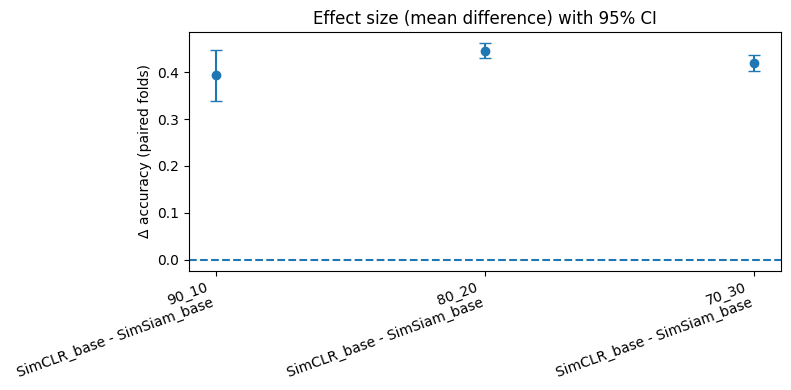

In [187]:
# Figure 1: Mean Δacc with 95% CI (baseline - ablation)
if len(fig_df):
    plt.figure(figsize=(8,4))
    x = np.arange(len(fig_df))
    y = fig_df["mean_diff"].to_numpy()
    yerr = np.vstack([y - fig_df["ci_lo"].to_numpy(), fig_df["ci_hi"].to_numpy() - y])
    plt.errorbar(x, y, yerr=yerr, fmt="o", capsize=4)
    plt.axhline(0, linestyle="--")
    plt.xticks(x, fig_df["grid"] + "\n" + fig_df["pair"], rotation=20, ha="right")
    plt.ylabel("Δ accuracy (paired folds)")
    plt.title("Effect size (mean difference) with 95% CI")
    plt.tight_layout()
    plt.show()
else:
    print("No ablation pairs found in COMPARES yet.")


## 11) Final notes for your write-up

In your report section:
- Mention **which grid** you used (same as Task 2) and **same folds** for paired comparisons.
- For each SSL, describe the **single ablation** clearly (what changed and why it matters).
- Discuss:
  - If p-value is small but Δacc is tiny → statistically significant but not practically meaningful.
  - If Δacc is big but p-value is marginal → likely underpowered; increase folds or repeats.

---

### What you still need to do (minimum)
1) Add at least one encoder checkpoint per ablation:
- `SimCLR_abl`
- `SimSiam_abl`

2) Update `COMPARES` list accordingly.

Then re-run Task 7 and paste:
- `lp_table`, `le_table`
- `stats_df` + Nemenyi tables
- Figure(s)
